<a href="https://colab.research.google.com/github/ThumbRocket/AI_Expert_Lecture_Files/blob/main/4Week/%EC%82%BC%EC%84%B1_%EC%8B%A4%EC%8A%B5_1%EC%9D%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ls

24.06.24.pdf   fra-eng.zip                 glove-wiki-gigaword-200.kv.vectors.npy
24.06.24.pptx  fra.txt                     LSTM_sentiment_analysis_model.h5
_about.txt     glove.6B.100d.txt           stock.csv
fra-eng/       glove-wiki-gigaword-200.kv  삼성_실습_1일차.ipynb


In [5]:
cd /content/drive/MyDrive/삼성_실습_1일차

/content/drive/.shortcut-targets-by-id/1CZTNjUenPehO_G-XhRKqzqD2x2_yi9mr/삼성_실습_1일차


In [6]:
!pip install -q datasets
!pip install transformers
!pip install yfinance numpy pandas matplotlib tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [7]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from tqdm import tqdm
import gensim.downloader as api
from gensim.models import KeyedVectors
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import pprint
import seaborn as sns

# 1. One-hot encoding 예제

In [8]:
# 단어 집합 (vocabulary)
vocab = ['king', 'queen', 'food', 'milk']

# One-Hot Encoding 함수
def one_hot_encode(word, vocab):
    one_hot_vector = np.zeros(len(vocab))
    index = vocab.index(word)
    one_hot_vector[index] = 1
    return one_hot_vector

# 단어들을 One-Hot Encoding으로 변환
king_vector = one_hot_encode('king', vocab)
queen_vector = one_hot_encode('queen', vocab)
food_vector = one_hot_encode('food', vocab)
milk_vector = one_hot_encode('milk', vocab)

# 벡터들 출력
print(f"'king'의 One-Hot Encoding: {king_vector}")
print(f"'queen'의 One-Hot Encoding: {queen_vector}")
print(f"'food'의 One-Hot Encoding: {food_vector}")
print(f"'milk'의 One-Hot Encoding: {milk_vector}")

'king'의 One-Hot Encoding: [1. 0. 0. 0.]
'queen'의 One-Hot Encoding: [0. 1. 0. 0.]
'food'의 One-Hot Encoding: [0. 0. 1. 0.]
'milk'의 One-Hot Encoding: [0. 0. 0. 1.]


In [9]:
# 코사인 유사도 계산
def cosine_similarity_custom(vec1, vec2):
    cos_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)) # vec1와 vec2 내적 -> similarity
    return cos_sim

'king'과 'queen'의 유사도 (One-Hot): 0.0
'king'과 'food'의 유사도 (One-Hot): 0.0
'king'과 'milk'의 유사도 (One-Hot): 0.0


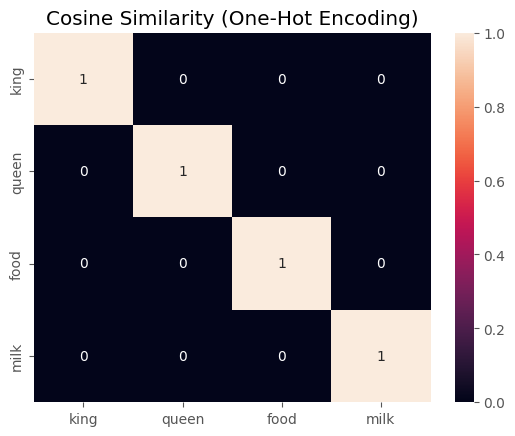

In [11]:
similarity_king_queen = cosine_similarity_custom(king_vector, queen_vector)
similarity_king_food = cosine_similarity_custom(king_vector, food_vector)
similarity_king_milk = cosine_similarity_custom(king_vector, milk_vector)

print(f"'king'과 'queen'의 유사도 (One-Hot): {similarity_king_queen}")
print(f"'king'과 'food'의 유사도 (One-Hot): {similarity_king_food}")
print(f"'king'과 'milk'의 유사도 (One-Hot): {similarity_king_milk}")

# 코사인 유사도 결과를 시각적으로 확인
cos_sim_matrix = cosine_similarity([king_vector, queen_vector, food_vector, milk_vector])

sns.heatmap(cos_sim_matrix, annot=True, xticklabels=vocab, yticklabels=vocab)
plt.title("Cosine Similarity (One-Hot Encoding)")
plt.show()

# 2. Word Embedding 예제


### 2-1. Word2Vec

In [12]:
sentences = [
    ['king', 'queen', 'man', 'woman'],
    ['food', 'milk', 'bread', 'cheese'],
    ['king', 'man', 'queen', 'woman'],
    ['milk', 'cheese', 'bread', 'food'],
    ['king', 'man'],
    ['queen', 'woman'],
    ['food', 'bread'],
    ['milk', 'cheese']
]

# Word2Vec 모델 학습
word2vec = Word2Vec(sentences, vector_size=50, window=2, min_count=1, sg=0) # vector_size 50차원

'king'과 'queen'의 유사도 (Word2Vec): 0.11253499239683151
'king'과 'food'의 유사도 (Word2Vec): 0.04491342231631279
'king'과 'milk'의 유사도 (Word2Vec): -0.2187258005142212


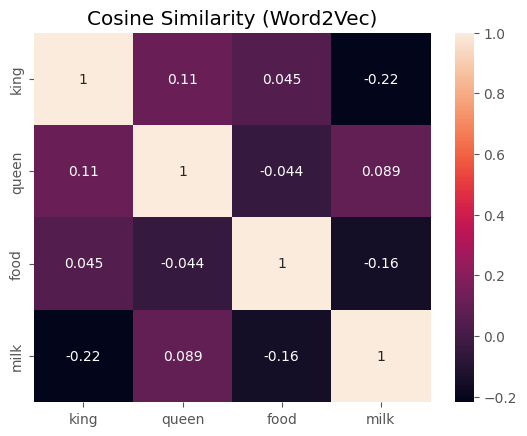

In [13]:
vocab = ['king', 'queen', 'food', 'milk']

corpus_embeddings = np.array([word2vec.wv[word] for word in vocab])

king_vector = corpus_embeddings[0]
queen_vector = corpus_embeddings[1]
food_vector = corpus_embeddings[2]
milk_vector = corpus_embeddings[3]

similarity_king_queen = cosine_similarity_custom(king_vector, queen_vector)
similarity_king_food = cosine_similarity_custom(king_vector, food_vector)
similarity_king_milk = cosine_similarity_custom(king_vector, milk_vector)

print(f"'king'과 'queen'의 유사도 (Word2Vec): {similarity_king_queen}")
print(f"'king'과 'food'의 유사도 (Word2Vec): {similarity_king_food}")
print(f"'king'과 'milk'의 유사도 (Word2Vec): {similarity_king_milk}")

# 코사인 유사도 결과를 시각적으로 확인
cos_sim_matrix = cosine_similarity([king_vector, queen_vector, food_vector, milk_vector])

sns.heatmap(cos_sim_matrix, annot=True, xticklabels=vocab, yticklabels=vocab)
plt.title("Cosine Similarity (Word2Vec)")
plt.show()

In [ ]:
word2vec.wv.similarity(vocab[0], vocab[1])

0.11253498

In [14]:
word2vec.wv.most_similar('king')

[('woman', 0.13662855327129364),
 ('cheese', 0.13204145431518555),
 ('queen', 0.11253499239683151),
 ('food', 0.044913437217473984),
 ('man', 0.029596175998449326),
 ('bread', -0.17547552287578583),
 ('milk', -0.21872581541538239)]

In [15]:
word2vec.wv.most_similar('bread')

[('woman', 0.12486250698566437),
 ('queen', 0.07399576157331467),
 ('cheese', 0.04237300902605057),
 ('man', 0.018277151510119438),
 ('milk', 0.011071980930864811),
 ('food', -0.17424818873405457),
 ('king', -0.17547553777694702)]

In [16]:
word2vec.wv.most_similar(positive = ['king', 'queen'])

[('man', 0.14278708398342133),
 ('woman', 0.05390901118516922),
 ('cheese', 0.04846587032079697),
 ('food', 0.0005640055751428008),
 ('bread', -0.06803111732006073),
 ('milk', -0.08714812248945236)]

### 2-2. GloVe

In [17]:
from gensim.models import KeyedVectors

def load_saved_embedding_model(file_path):
    """ Load saved GloVe Vectors from file
        Args:
            file_path: path to the saved file
        Return:
            wv_from_bin: All embeddings loaded from file
    """
    wv_from_bin = KeyedVectors.load(file_path, mmap='r')
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

# 파일에서 로드
glove = load_saved_embedding_model("glove-wiki-gigaword-200.kv")

Loaded vocab size 400000


In [ ]:
vocab = ['king', 'queen', 'food', 'milk']

In [18]:
# Print the dimension of the GloVe vectors
print(f'Dimensions of the GloVe vectors: {glove.vectors.shape}')

# Sample corpus embedding from Glove
corpus_embeddings = np.array([glove[word] for word in vocab])

Dimensions of the GloVe vectors: (400000, 200)


'king'과 'queen'의 유사도 (GloVe): 0.6665197610855103
'king'과 'food'의 유사도 (GloVe): 0.22469617426395416
'king'과 'milk'의 유사도 (GloVe): 0.14077116549015045


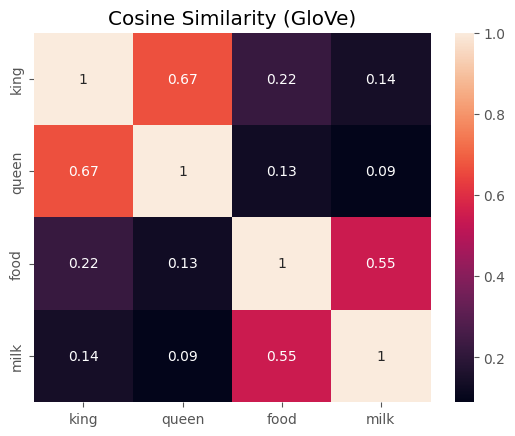

In [19]:
king_vector = corpus_embeddings[0]
queen_vector = corpus_embeddings[1]
food_vector = corpus_embeddings[2]
milk_vector = corpus_embeddings[3]

similarity_king_queen = cosine_similarity_custom(king_vector, queen_vector)
similarity_king_food = cosine_similarity_custom(king_vector, food_vector)
similarity_king_milk = cosine_similarity_custom(king_vector, milk_vector)

print(f"'king'과 'queen'의 유사도 (GloVe): {similarity_king_queen}")
print(f"'king'과 'food'의 유사도 (GloVe): {similarity_king_food}")
print(f"'king'과 'milk'의 유사도 (GloVe): {similarity_king_milk}")

# 코사인 유사도 결과를 시각적으로 확인
cos_sim_matrix = cosine_similarity([king_vector, queen_vector, food_vector, milk_vector])

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cos_sim_matrix, annot=True, xticklabels=vocab, yticklabels=vocab)
plt.title("Cosine Similarity (GloVe)")
plt.show()

In [20]:
pprint.pprint(glove.similarity('king', 'queen'))

0.6665197


In [ ]:
pprint.pprint(glove.most_similar('king'))

[('prince', 0.6854567527770996),
 ('queen', 0.6665196418762207),
 ('kingdom', 0.6303210258483887),
 ('monarch', 0.6224350333213806),
 ('ii', 0.6146443486213684),
 ('throne', 0.6074705123901367),
 ('reign', 0.5911680459976196),
 ('iii', 0.583712637424469),
 ('crown', 0.579647958278656),
 ('emperor', 0.5552704334259033)]


In [ ]:
pprint.pprint(glove.most_similar(positive=['king', 'queen'], negative = ['princess']))

[('monarch', 0.5550335049629211),
 ('ii', 0.502287745475769),
 ('kingdom', 0.5022493004798889),
 ('reign', 0.4935906231403351),
 ('throne', 0.47744500637054443),
 ('henry', 0.473604679107666),
 ('iii', 0.4697798490524292),
 ('vi', 0.45458969473838806),
 ('kings', 0.4501577615737915),
 ('crown', 0.44721829891204834)]


In [21]:
corpus_embeddings[0]

array([-0.49346  , -0.14768  ,  0.32166  ,  0.056899 ,  0.052572 ,
        0.20192  , -0.13506  , -0.030793 ,  0.15614  , -0.23004  ,
       -0.66376  , -0.27316  ,  0.10391  ,  0.57334  , -0.032355 ,
       -0.32766  , -0.2716   ,  0.32919  ,  0.41305  , -0.18085  ,
        1.5167   ,  2.1649   , -0.10278  ,  0.098019 , -0.018946 ,
        0.027292 , -0.7948   ,  0.36631  , -0.33151  ,  0.2884   ,
        0.10436  , -0.19166  ,  0.27326  , -0.17519  , -0.14986  ,
       -0.072333 , -0.54371  , -0.29728  ,  0.081491 , -0.42673  ,
       -0.36406  , -0.52035  ,  0.18455  ,  0.44121  , -0.32196  ,
        0.39172  ,  0.11952  ,  0.36979  ,  0.29229  , -0.42954  ,
        0.46653  , -0.067243 ,  0.31216  , -0.17216  ,  0.48874  ,
        0.2803   , -0.17577  , -0.35101  ,  0.020792 ,  0.15974  ,
        0.21927  , -0.32499  ,  0.086022 ,  0.38927  , -0.65638  ,
       -0.67401  , -0.41896  ,  1.2709   ,  0.20857  ,  0.28315  ,
        0.58238  , -0.14944  ,  0.3989   ,  0.52681  ,  0.3571

# Task 1: Word Embedding

### 1) 원하는 단어들 중 관련 없는 것 예측하고, 실제로 그것이 출력되는지 확인해보기


In [24]:
vocab_list = list(glove.index_to_key)

In [26]:
# 원하는 단어가 있는지 확인(소문자로 검색) - True
word = 'samsung'
print(word in vocab_list)

True


In [27]:
print(glove.doesnt_match("breakfast cereal dinner lunch".split())) # 4개 단어 중 연관이 없는 단어 1개 선택

cereal


In [29]:
print(glove.doesnt_match("samsung kaist yonsei".split()))

samsung


In [30]:
print(glove.doesnt_match("golf baseball dance".split()))

dance


In [34]:
# Do yourself
you = "computer snack keyboard mouse"
print(glove.doesnt_match(you.split()))

snack


### 2) 4개 이상의 단어들을 입력하고 유사도가 높은 단어들끼리 매칭되는지 결과 확인해보기

In [36]:
def cosine_similarity_custom(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def display_pca_scatterplot(model, words=None, sample=0):
    if words is None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [word for word in model.vocab]

    # 단어 벡터 추출
    word_vectors = np.array([model[w] for w in words])

    # PCA 수행
    pca = PCA(n_components=2)
    twodim = pca.fit_transform(word_vectors)[:, :2]

    # 단어 시각화
    plt.figure(figsize=(10, 10))
    plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, twodim):
        plt.annotate(word, (x, y), xytext=(x + 0.05, y + 0.05))

    # 유사한 단어 쌍 연결
    for i in range(len(words)):
        similarities = []
        for j in range(len(words)):
            if i != j:
                cos_sim = cosine_similarity_custom(word_vectors[i], word_vectors[j])
                similarities.append((cos_sim, i, j))
        # 가장 유사한 단어 쌍 찾기
        most_similar = max(similarities, key=lambda item: item[0])
        _, idx1, idx2 = most_similar
        plt.plot([twodim[idx1, 0], twodim[idx2, 0]], [twodim[idx1, 1], twodim[idx2, 1]], 'k--', linewidth=0.5)

    plt.show()

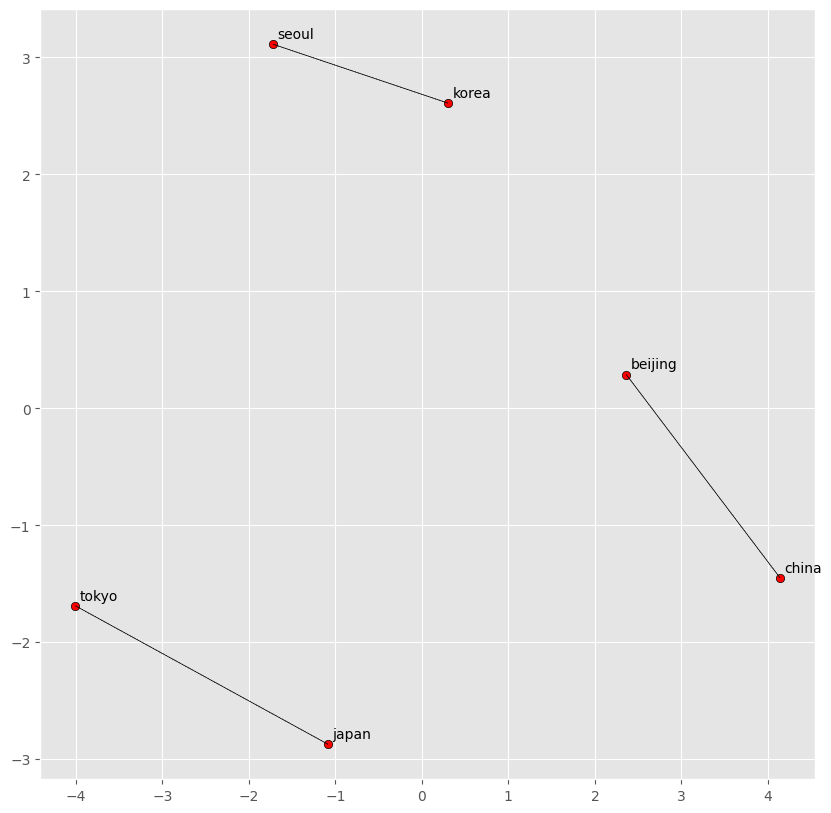

In [37]:
display_pca_scatterplot(glove,
    ['korea', 'seoul', 'japan', 'tokyo', 'china', 'beijing'])

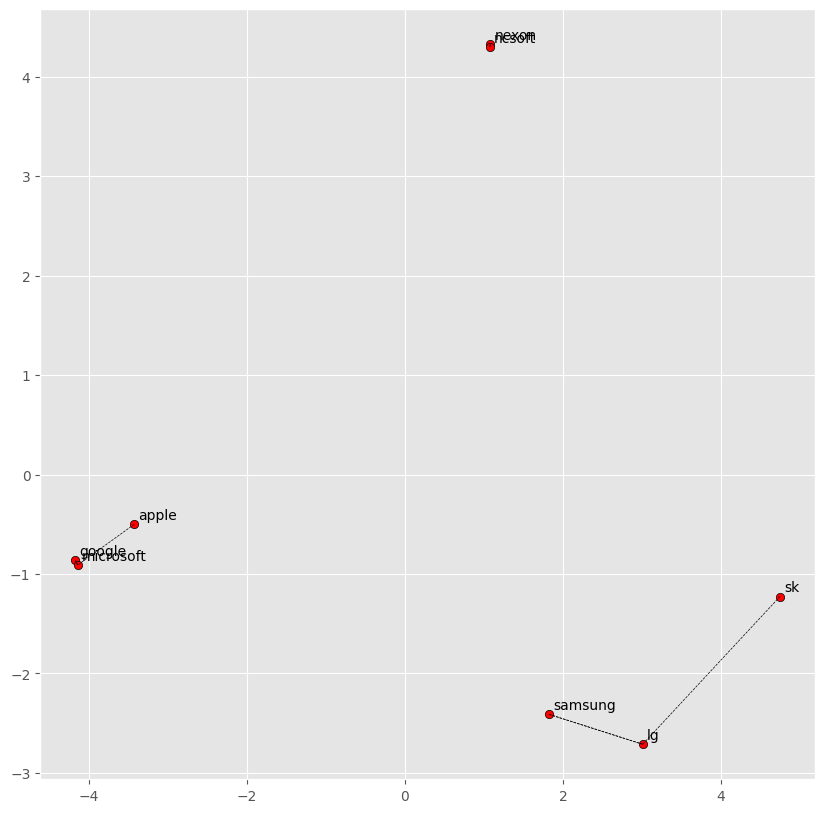

In [44]:
display_pca_scatterplot(glove,
    ['samsung', 'lg', 'sk', 'nexon', 'ncsoft', 'google', 'microsoft', 'apple'])

In [ ]:
# Do yourself
display_pca_scatterplot(glove,
    [])

### 3) GloVe 빈칸 채워서 유사한 단어 찾기

In [53]:
import numpy as np

# GloVe 파일 로드 (다운로드된 파일 경로로 변경 필요)
glove_file = 'glove.6B.100d.txt'
embedding_dict = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            vector = np.asarray(values[1:], dtype='float32')
            if vector.shape[0] == 100:  # 벡터의 길이가 100인지 확인
                embedding_dict[word] = vector
        except ValueError:
            print(f"Error converting line to float: {line}")

# 단어 벡터 얻기
def get_word_vector(word):
    return embedding_dict.get(word, np.zeros((100,)))[:100]

# cosine 유사도 계산
def cosine_similarity_custom(vec1, vec2):
    # Do yourself!
    similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return similarity

# 유사한 단어 찾기 함수 (코사인 유사도)
def find_similar_words(word, top_n=5):
    target_vector = get_word_vector(word)
    similarities = {}
    for w, vec in embedding_dict.items():
        if word == w:
          continue
        similarities[w] = cosine_similarity_custom(target_vector, vec)

    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]

# 특정 단어와 유사한 단어들 찾기
similar_words_glove = find_similar_words('starcraft')
print(f"'samsung'과 유사한 단어들 (GloVe): {similar_words_glove}")


'samsung'과 유사한 단어들 (GloVe): [('warcraft', 0.76388866), ('everquest', 0.6020596), ('shenmue', 0.5900681), ('kombat', 0.57015586), ('dota', 0.5611353)]


# 3. Sequential Learning 예제

### 3-1. RNN

In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [55]:
# 예제 데이터 준비 (텍스트를 단어 인덱스로 변환)
text = "hello world machine learning deep learning natural language processing"
vocab = sorted(set(text.split()))
word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for i, w in enumerate(vocab)}
sequences = [word_to_index[w] for w in text.split()]

In [59]:
vocab, sequences, list(index_to_word[i] for i in sequences)

(['deep',
  'hello',
  'language',
  'learning',
  'machine',
  'natural',
  'processing',
  'world'],
 [1, 7, 4, 3, 0, 3, 5, 2, 6],
 ['hello',
  'world',
  'machine',
  'learning',
  'deep',
  'learning',
  'natural',
  'language',
  'processing'])

In [60]:
# 데이터셋 준비
def create_dataset(seq, step=3):
    x, y = [], []
    for i in range(0, len(seq) - step):
        x.append(seq[i:i+step])
        y.append(seq[i+step])
    return np.array(x), np.array(y)

X, y = create_dataset(sequences)

In [62]:
# 모델 구성
model = Sequential()
model.add(Embedding(input_dim=len(vocab), output_dim=10, input_length=3))
model.add(SimpleRNN(50))
model.add(Dense(len(vocab), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [63]:
# 모델 훈련
model.fit(X, y, epochs=200, verbose=0)

In [64]:
# 텍스트 생성 함수
def generate_text(seed_text, num_words):
    result = seed_text.split()
    for _ in range(num_words):
        encoded = [word_to_index.get(w, 0) for w in result[-3:]]
        encoded = pad_sequences([encoded], maxlen=3)  # 패딩 사용
        predicted = model.predict(encoded, verbose=0)
        next_word = index_to_word[np.argmax(predicted)]
        result.append(next_word)
    return ' '.join(result)

In [68]:
# 텍스트 생성 예제
# hello world machine learning deep learning natural language processing
seed_text = "hello"
# seed_text = "hello world"
# seed_text = "hello world machine"
# seed_text = "hello world machine learning"
generated_text = generate_text(seed_text, 5)
print(f"생성된 텍스트: {generated_text}")

생성된 텍스트: hello language language learning deep learning


In [69]:
# 텍스트 생성 예제
# hello world machine learning deep learning natural language processing
#seed_text = "hello"
seed_text = "hello world"
# seed_text = "hello world machine"
# seed_text = "hello world machine learning"
generated_text = generate_text(seed_text, 5)
print(f"생성된 텍스트: {generated_text}")

생성된 텍스트: hello world language learning deep learning natural


In [70]:
# 텍스트 생성 예제
# hello world machine learning deep learning natural language processing
#seed_text = "hello"
#seed_text = "hello world"
seed_text = "hello world machine"
# seed_text = "hello world machine learning"
generated_text = generate_text(seed_text, 5)
print(f"생성된 텍스트: {generated_text}")

생성된 텍스트: hello world machine learning deep learning natural language


In [71]:
# 텍스트 생성 예제
# hello world machine learning deep learning natural language processing
#seed_text = "hello"
#seed_text = "hello world"
# seed_text = "hello world machine"
seed_text = "hello world machine learning"
generated_text = generate_text(seed_text, 5)
print(f"생성된 텍스트: {generated_text}")

생성된 텍스트: hello world machine learning deep learning natural language processing


### 3-2. LSTM

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import load_model

In [87]:
# IMDb 데이터셋 로드
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=20000)
maxlen = 100
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [79]:
X_train

array([[1415,   33,    6, ...,   19,  178,   32],
       [ 163,   11, 3215, ...,   16,  145,   95],
       [1301,    4, 1873, ...,    7,  129,  113],
       ...,
       [  11,    6, 4065, ...,    4, 3586,    2],
       [ 100, 2198,    8, ...,   12,    9,   23],
       [  78, 1099,   17, ...,  204,  131,    9]], dtype=int32)

In [76]:
X_test.shape

(25000, 100)

In [ ]:
# 모델 구성
# model = Sequential()
# model.add(Embedding(input_dim=20000, output_dim=128, input_length=maxlen))
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 훈련
# model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
782/782 [==============================] - 360s 454ms/step - loss: 0.4279 - accuracy: 0.8032 - val_loss: 0.3458 - val_accuracy: 0.8502
Epoch 2/5
782/782 [==============================] - 350s 447ms/step - loss: 0.2461 - accuracy: 0.9038 - val_loss: 0.4346 - val_accuracy: 0.8228
Epoch 3/5
782/782 [==============================] - 360s 461ms/step - loss: 0.1644 - accuracy: 0.9381 - val_loss: 0.4512 - val_accuracy: 0.8353
Epoch 4/5
782/782 [==============================] - 359s 459ms/step - loss: 0.1002 - accuracy: 0.9642 - val_loss: 0.5439 - val_accuracy: 0.8338
Epoch 5/5
782/782 [==============================] - 370s 473ms/step - loss: 0.0694 - accuracy: 0.9763 - val_loss: 0.6202 - val_accuracy: 0.8268


In [85]:
model = load_model('LSTM_sentiment_analysis_model.h5')

In [88]:
# 모델 평가
score, acc = model.evaluate(X_test, y_test, batch_size=32)
print(f'테스트 정확도: {acc}')

782/782 [==============================] - 34s 43ms/step - loss: 0.6202 - accuracy: 0.8268
테스트 정확도: 0.8268399834632874


In [112]:
# 새로운 리뷰에 대한 예측
def predict_sentiment(review, word_to_index, model, maxlen=100):
    # 리뷰를 정수 인덱스로 변환
    print(review.split())
    encoded_review = [word_to_index.get(word, 0) for word in review.split()]
    print(encoded_review)
    padded_review = sequence.pad_sequences([encoded_review], maxlen=maxlen)
    # 예측
    prediction = model.predict(padded_review)
    return prediction[0][0]

# IMDb 데이터셋의 단어 사전
word_index = imdb.get_word_index()

In [157]:
a = word_index.get("shit", 0)
print(a)

24632


In [155]:
# 예측 테스트
new_review = "this movie was not funny."
#new_review = "shit this moive."
predicted_sentiment = predict_sentiment(new_review, word_index, model, maxlen=maxlen)
print(f'리뷰: "{new_review}"')
print(f'예측된 감정 (0 = 부정적, 1 = 긍정적): {predicted_sentiment}')
if predicted_sentiment > 0.5 :
  result = '긍정'
else:
  result= '부정'
print(result)

['this', 'movie', 'was', 'not', 'funny.']
[11, 17, 13, 21, 0]
1/1 [==============================] - 0s 76ms/step
리뷰: "this movie was not funny."
예측된 감정 (0 = 부정적, 1 = 긍정적): 0.5392438769340515
긍정


# Task 2: Sequential Learning

### 1) 번역기 만들기(영-프)

#### 1-1) LSTM

In [147]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [148]:
# 예시 데이터셋
english_sentences = [
    'he is a good boy',
    'she is a beautiful girl',
    'they are playing outside',
    'we are learning LSTM',
    'what is your name',
    'where is the library',
    'when will you come',
    'why are you crying',
    'how are you today',
    'i am fine thank you'
]

french_sentences = [
    'il est un bon garçon',
    'elle est une belle fille',
    'ils jouent dehors',
    'nous apprenons LSTM',
    'quel est ton nom',
    'où est la bibliothèque',
    'quand viendrez-vous',
    'pourquoi pleures-tu',
    'comment allez-vous aujourd\'hui',
    'je vais bien merci'
]


In [149]:
lstm_eng_tokenizer = Tokenizer()
lstm_eng_tokenizer.fit_on_texts(english_sentences)
lstm_eng_vocab_size = len(lstm_eng_tokenizer.word_index) + 1
lstm_eng_sequences = lstm_eng_tokenizer.texts_to_sequences(english_sentences)

lstm_fra_tokenizer = Tokenizer()
lstm_fra_tokenizer.fit_on_texts(french_sentences)
lstm_fra_vocab_size = len(lstm_fra_tokenizer.word_index) + 1
lstm_fra_sequences = lstm_fra_tokenizer.texts_to_sequences(french_sentences)

lstm_max_length_eng = max(len(seq) for seq in lstm_eng_sequences)
lstm_max_length_fra = max(len(seq) for seq in lstm_fra_sequences)

# Padding sequences
lstm_eng_sequences = pad_sequences(lstm_eng_sequences, maxlen=lstm_max_length_eng, padding='post')
lstm_fra_sequences = pad_sequences(lstm_fra_sequences, maxlen=lstm_max_length_fra, padding='post')

lstm_fra_input = lstm_fra_sequences[:, :-1]
lstm_fra_output = to_categorical(lstm_fra_sequences[:, 1:], num_classes=lstm_fra_vocab_size)

# 모델 구성
lstm_model = Sequential()
lstm_model.add(Embedding(lstm_eng_vocab_size, 256, input_length=lstm_max_length_eng, mask_zero=True))
lstm_model.add(LSTM(256))
lstm_model.add(RepeatVector(lstm_max_length_fra - 1))
lstm_model.add(LSTM(256, return_sequences=True))
lstm_model.add(Dense(lstm_fra_vocab_size, activation='softmax'))

# 모델 컴파일
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
lstm_model.fit(lstm_eng_sequences, lstm_fra_output, epochs=100)

# 예측 함수
def LSTM_translate(sentence):
    lstm_seq = lstm_eng_tokenizer.texts_to_sequences([sentence])
    lstm_seq = pad_sequences(lstm_seq, maxlen=lstm_max_length_eng, padding='post')
    lstm_prediction = lstm_model.predict(lstm_seq)
    lstm_prediction = np.argmax(lstm_prediction, axis=-1)
    lstm_predicted_sentence = ' '.join([lstm_fra_tokenizer.index_word[idx] for idx in lstm_prediction[0] if idx > 0])
    return lstm_predicted_sentence

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 3.5559 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 34ms/step - loss: 3.5423 - accuracy: 0.3000
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 3.5266 - accuracy: 0.3000
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 3.5060 - accuracy: 0.3000
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 3.4770 - accuracy: 0.3000
Epoch 6/100
1/1 [==============================] - 0s 35ms/step - loss: 3.4352 - accuracy: 0.3000
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 3.3744 - accuracy: 0.3000
Epoch 8/100
1/1 [==============================] - 0s 35ms/step - loss: 3.2857 - accuracy: 0.3000
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 3.1576 - accuracy: 0.3000
Epoch 10/100
1/1 [==============================] - 0s 37ms/step - loss: 2.9799 - accuracy: 0.3000
Epoch 11/100
1/1 

#### 1-2) RNN

In [150]:
# 토큰화 및 패딩
rnn_eng_tokenizer = Tokenizer()
rnn_eng_tokenizer.fit_on_texts(english_sentences)
rnn_eng_vocab_size = len(rnn_eng_tokenizer.word_index) + 1
rnn_eng_sequences = rnn_eng_tokenizer.texts_to_sequences(english_sentences)
rnn_max_length_eng = max(len(seq) for seq in rnn_eng_sequences)
rnn_eng_sequences = pad_sequences(rnn_eng_sequences, maxlen=rnn_max_length_eng, padding='post')

rnn_fra_tokenizer = Tokenizer()
rnn_fra_tokenizer.fit_on_texts(french_sentences)
rnn_fra_vocab_size = len(rnn_fra_tokenizer.word_index) + 1
rnn_fra_sequences = rnn_fra_tokenizer.texts_to_sequences(french_sentences)
rnn_max_length_fra = max(len(seq) for seq in rnn_fra_sequences)
rnn_fra_sequences = pad_sequences(rnn_fra_sequences, maxlen=rnn_max_length_fra, padding='post')

# 입력과 출력 시퀀스의 길이를 맞추기 위해 수정
rnn_eng_input = rnn_eng_sequences[:, :-1]
rnn_fra_input = rnn_fra_sequences[:, :-1]
rnn_fra_output = to_categorical(rnn_fra_sequences[:, 1:], num_classes=rnn_fra_vocab_size)

# 모델 구성
rnn_model = Sequential()
rnn_model.add(Embedding(rnn_eng_vocab_size, 256, input_length=rnn_max_length_eng-1))
rnn_model.add(SimpleRNN(256, return_sequences=True))
rnn_model.add(Dense(rnn_fra_vocab_size, activation='softmax'))

# 모델 컴파일
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
rnn_model.fit(rnn_eng_input, rnn_fra_output, epochs=100)

# 예측 함수
def RNN_translate(sentence):
    rnn_seq = rnn_eng_tokenizer.texts_to_sequences([sentence])
    rnn_seq = pad_sequences(rnn_seq, maxlen=rnn_max_length_eng-1, padding='post')
    rnn_prediction = rnn_model.predict(rnn_seq)
    rnn_prediction = np.argmax(rnn_prediction, axis=-1)
    rnn_predicted_sentence = ' '.join([rnn_fra_tokenizer.index_word[idx] for idx in rnn_prediction[0] if idx > 0])
    return rnn_predicted_sentence

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 3.5475 - accuracy: 0.0250
Epoch 2/100
1/1 [==============================] - 0s 26ms/step - loss: 3.4424 - accuracy: 0.4250
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 3.3337 - accuracy: 0.6500
Epoch 4/100
1/1 [==============================] - 0s 17ms/step - loss: 3.2145 - accuracy: 0.7500
Epoch 5/100
1/1 [==============================] - 0s 18ms/step - loss: 3.0791 - accuracy: 0.8500
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 2.9233 - accuracy: 0.8750
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 2.7482 - accuracy: 0.9000
Epoch 8/100
1/1 [==============================] - 0s 17ms/step - loss: 2.5655 - accuracy: 0.9000
Epoch 9/100
1/1 [==============================] - 0s 20ms/step - loss: 2.3979 - accuracy: 0.9000
Epoch 10/100
1/1 [==============================] - 0s 19ms/step - loss: 2.2632 - accuracy: 0.8750
Epoch 11/100
1/1 [===

#### 1-3) 결과 비교

In [165]:
# LSTM
# 예제 문장 번역
test_sentence = "she is a beautiful girl"  # 정답: Il est mon ami
translated_sentence = LSTM_translate(test_sentence)
print(f'Input: {test_sentence}')
print(f'Translated: {translated_sentence}')

1/1 [==============================] - 0s 43ms/step
Input: she is a beautiful girl
Translated: est une belle fille


In [164]:
# RNN
# 예제 문장 번역
test_sentence = "she is a beautiful girl"
translated_sentence = RNN_translate(test_sentence)
print(f'Input: {test_sentence}')
print(f'Translated: {translated_sentence}')

1/1 [==============================] - 0s 47ms/step
Input: she is a beautiful girl
Translated: un bon fille


### 2) 주식 예측하기

#### 2-1) LSTM

In [129]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [130]:
data = pd.read_csv('stock.csv')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

In [131]:
data

,Date,Close
0,2020-01-02,68.433998
1,2020-01-03,68.075996
2,2020-01-06,69.890503
3,2020-01-07,69.755501
4,2020-01-08,70.251999
...,...,...
751,2022-12-23,89.230003
752,2022-12-27,87.389999
753,2022-12-28,86.019997
754,2022-12-29,88.449997


In [133]:
# 시계열 데이터셋 생성 함수
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # 60일을 하나의 입력 시퀀스로 사용
X, y = create_dataset(scaled_data, time_step)

# 데이터 분할
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 데이터 형태 변경 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [134]:
# LSTM 모델 구성
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

# 모델 컴파일
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
lstm_model.fit(X_train, y_train, batch_size=1, epochs=1)

# 예측
lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)

# 예측값 역정규화
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)

556/556 [==============================] - 18s 26ms/step - loss: 0.0077


5/5 [==============================] - 0s 13ms/step


#### 2-2) RNN

In [135]:
# RNN 모델 구성
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
rnn_model.add(SimpleRNN(50, return_sequences=False))
rnn_model.add(Dense(25))
rnn_model.add(Dense(1))

# 모델 컴파일
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
rnn_model.fit(X_train, y_train, batch_size=1, epochs=1)

# 예측
rnn_train_predict = rnn_model.predict(X_train)
rnn_test_predict = rnn_model.predict(X_test)

# 예측값 역정규화
rnn_train_predict = scaler.inverse_transform(rnn_train_predict)
rnn_test_predict = scaler.inverse_transform(rnn_test_predict)

5/5 [==============================] - 0s 7ms/step


#### 2-3) 결과 비교

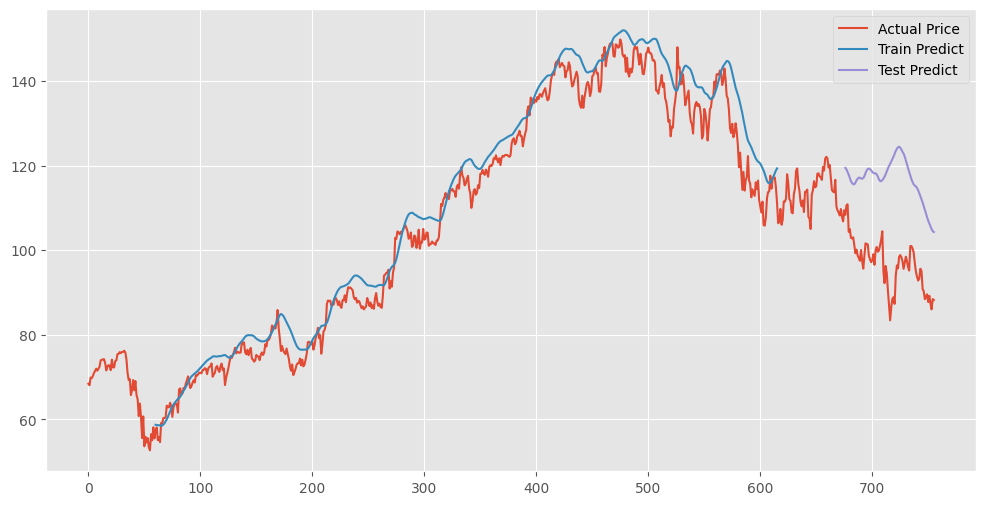

In [136]:
# LSTM
# 실제값과 예측값 시각화
plt.figure(figsize=(12, 6))

# 실제값
plt.plot(data.index, data['Close'], label='Actual Price')

# 학습 데이터 예측값
lstm_train_predict_plot = np.empty_like(scaled_data)
lstm_train_predict_plot[:, :] = np.nan
lstm_train_predict_plot[time_step:len(lstm_train_predict) + time_step, :] = lstm_train_predict

# 테스트 데이터 예측값
lstm_test_predict_plot = np.empty_like(scaled_data)
lstm_test_predict_plot[:, :] = np.nan
lstm_test_predict_plot[len(lstm_train_predict) + (time_step * 2):len(scaled_data), :] = lstm_test_predict[:len(scaled_data) - (len(lstm_train_predict) + (time_step * 2)), :]

# 시각화
plt.plot(data.index, lstm_train_predict_plot, label='Train Predict')
plt.plot(data.index, lstm_test_predict_plot, label='Test Predict')

plt.legend()
plt.show()

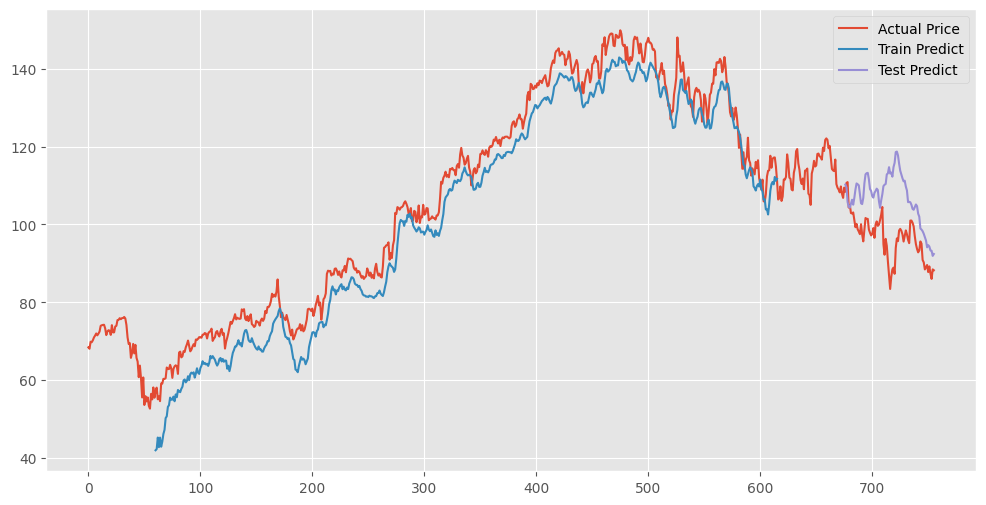

In [137]:
# RNN
# 실제값과 예측값 시각화
plt.figure(figsize=(12, 6))

# 실제값
plt.plot(data.index, data['Close'], label='Actual Price')

# 학습 데이터 예측값
rnn_train_predict_plot = np.empty_like(scaled_data)
rnn_train_predict_plot[:, :] = np.nan
rnn_train_predict_plot[time_step:len(rnn_train_predict) + time_step, :] = rnn_train_predict

# 테스트 데이터 예측값
rnn_test_predict_plot = np.empty_like(scaled_data)
rnn_test_predict_plot[:, :] = np.nan
rnn_test_predict_plot[len(rnn_train_predict) + (time_step * 2):len(scaled_data), :] = rnn_test_predict[:len(scaled_data) - (len(rnn_train_predict) + (time_step * 2)), :]

# 시각화
plt.plot(data.index, rnn_train_predict_plot, label='Train Predict')
plt.plot(data.index, rnn_test_predict_plot, label='Test Predict')

plt.legend()
plt.show()

### 3) 기후 예측하기

#### 3-1) LSTM

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [139]:
# 데이터 로드
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
data = pd.read_csv(url)

# 데이터 확인
print(data.head())

# 날짜를 인덱스로 설정
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# 기온만 사용
temperature_data = data['Temp'].values.reshape(-1, 1)

# 데이터 전처리 (정규화)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(temperature_data)

# 시계열 데이터셋 생성 함수
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # 60일을 하나의 입력 시퀀스로 사용
X, y = create_dataset(scaled_data, time_step)

# 데이터 분할
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 데이터 형태 변경 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8


In [140]:
# LSTM 모델 구성
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

# 모델 컴파일
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
lstm_model.fit(X_train, y_train, batch_size=1, epochs=1)

# 예측
lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)

# 예측값 역정규화
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)

23/23 [==============================] - 0s 20ms/step


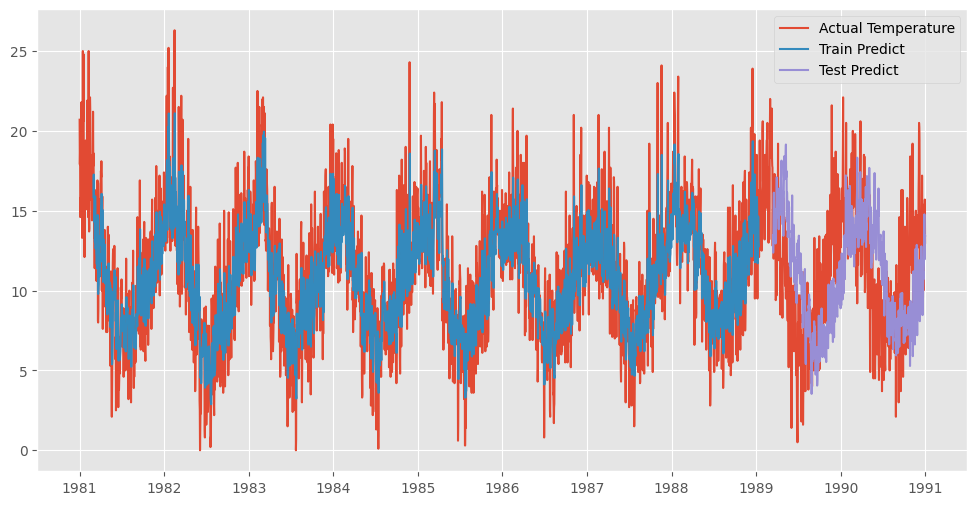

In [141]:
# 실제값과 예측값 시각화
plt.figure(figsize=(12, 6))

# 실제값
plt.plot(data.index, data['Temp'], label='Actual Temperature')

# 학습 데이터 예측값
lstm_train_predict_plot = np.empty_like(scaled_data)
lstm_train_predict_plot[:, :] = np.nan
lstm_train_predict_plot[time_step:len(lstm_train_predict) + time_step, :] = lstm_train_predict

# 테스트 데이터 예측값
lstm_test_predict_plot = np.empty_like(scaled_data)
lstm_test_predict_plot[:, :] = np.nan
lstm_test_predict_plot[len(lstm_train_predict) + (time_step * 2):len(scaled_data), :] = lstm_test_predict[:len(scaled_data) - (len(lstm_train_predict) + (time_step * 2)), :]

# 시각화
plt.plot(data.index, lstm_train_predict_plot, label='Train Predict')
plt.plot(data.index, lstm_test_predict_plot, label='Test Predict')

plt.legend()
plt.show()


#### 3-2) LSTM 구조 빈칸 채우기

In [143]:
import tensorflow as tf

class CustomLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CustomLSTMCell, self).__init__()
        self.units = units
        self.state_size = (units, units)  # LSTM 셀의 state_size 정의 (hidden state, cell state)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.Wxi = self.add_weight(shape=(input_dim, self.units), initializer='uniform', name='Wxi')
        self.Whi = self.add_weight(shape=(self.units, self.units), initializer='uniform', name='Whi')
        self.bi = self.add_weight(shape=(self.units,), initializer='zeros', name='bi')

        self.Wxf = self.add_weight(shape=(input_dim, self.units), initializer='uniform', name='Wxf')
        self.Whf = self.add_weight(shape=(self.units, self.units), initializer='uniform', name='Whf')
        self.bf = self.add_weight(shape=(self.units,), initializer='zeros', name='bf')

        self.Wxg = self.add_weight(shape=(input_dim, self.units), initializer='uniform', name='Wxg')
        self.Whg = self.add_weight(shape=(self.units, self.units), initializer='uniform', name='Whg')
        self.bg = self.add_weight(shape=(self.units,), initializer='zeros', name='bg')

        self.Wxo = self.add_weight(shape=(input_dim, self.units), initializer='uniform', name='Wxo')
        self.Who = self.add_weight(shape=(self.units, self.units), initializer='uniform', name='Who')
        self.bo = self.add_weight(shape=(self.units,), initializer='zeros', name='bo')

        self.built = True

    def call(self, inputs, states):
        h_tm1, c_tm1 = states

        # 입력 게이트
        i_t = tf.sigmoid(tf.matmul(inputs, self.Wxi) + tf.matmul(h_tm1, self.Whi) + self.bi)


        # Do yourself!
        # 망각 게이트
        f_t = tf.sigmoid(tf.matmul(inputs, self.Wxf) + tf.matmul(h_tm1, self.Whf) + self.bf)

        # 셀 상태에 대한 후보 값
        g_t = tf.tanh(tf.matmul(inputs, self.Wxg) + tf.matmul(h_tm1, self.Whg) + self.bg)

        # 출력 게이트
        o_t = tf.sigmoid(tf.matmul(inputs, self.Wxo) + tf.matmul(h_tm1, self.Who) + self.bo)

        # 셀 상태 업데이트
        c_t = f_t * c_tm1 + i_t * g_t

        # 출력 계산
        h_t = o_t * tf.tanh(c_t)

        return h_t, [h_t, c_t]


In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, Dense

# 모델 구성
custom_model = Sequential()

# LSTM 셀 추가
custom_model.add(RNN(CustomLSTMCell(50), return_sequences=True, input_shape=(time_step, 1)))
custom_model.add(RNN(CustomLSTMCell(50), return_sequences=False))

# Dense 레이어 추가
custom_model.add(Dense(units=25, activation='relu'))

# 출력 Dense 레이어 추가
custom_model.add(Dense(units=1))

# 모델 컴파일
custom_model.compile(optimizer='adam', loss='mean_squared_error')

In [145]:
# 모델 학습
custom_model.fit(X_train, y_train, batch_size=1, epochs=1)

# 예측
custom_train_predict = custom_model.predict(X_train)
custom_test_predict = custom_model.predict(X_test)

# 예측값 역정규화
custom_train_predict = scaler.inverse_transform(custom_train_predict)
custom_test_predict = scaler.inverse_transform(custom_test_predict)

23/23 [==============================] - 0s 17ms/step


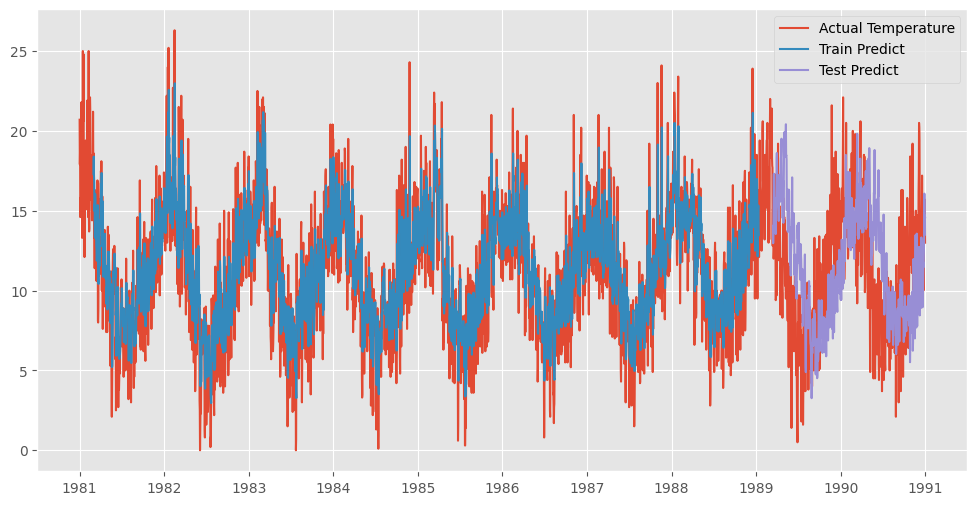

In [146]:
# 실제값과 예측값 시각화
plt.figure(figsize=(12, 6))

# 실제값
plt.plot(data.index, data['Temp'], label='Actual Temperature')

# 학습 데이터 예측값
custom_train_predict_plot = np.empty_like(scaled_data)
custom_train_predict_plot[:, :] = np.nan
custom_train_predict_plot[time_step:len(custom_train_predict) + time_step, :] = custom_train_predict

# 테스트 데이터 예측값
custom_test_predict_plot = np.empty_like(scaled_data)
custom_test_predict_plot[:, :] = np.nan
custom_test_predict_plot[len(custom_train_predict) + (time_step * 2):len(scaled_data), :] = custom_test_predict[:len(scaled_data) - (len(custom_train_predict) + (time_step * 2)), :]

# 시각화
plt.plot(data.index, custom_train_predict_plot, label='Train Predict')
plt.plot(data.index, custom_test_predict_plot, label='Test Predict')

plt.legend()
plt.show()
